In [12]:
using RxInfer, Random, LinearAlgebra, Plots, Flux, Plots, StableRNGs, SpecialFunctions, Rocket
using CCMP

In [15]:
@rule DeltaFn(:out, Marginalisation) (q_ins::ReactiveMP.FactorizedJoint{P}, meta::ReactiveMP.DeltaMeta{M}) where {P <: NTuple{1}, M <: CVI} = begin
    method = ReactiveMP.getmethod(meta)
    node = ReactiveMP.getnode()
    m_out = Rocket.getrecent(ReactiveMP.messagein(node.out))
    m_ins = Rocket.getrecent.(ReactiveMP.messagein.(node.ins))
    return convert(Distribution, naturalparams(prod(method, m_ins[1], m_out, q_ins[1], getnodefn(Val(:out)))) - naturalparams(m_out))
end

In [4]:
# data generating process
nr_observations = 50
reference_point = 53
hidden_location = collect(1:nr_observations) + rand(MersenneTwister(124), NormalMeanVariance(0.0, sqrt(5)), nr_observations)
measurements = (hidden_location .- reference_point).^2 + rand(MersenneTwister(124), NormalMeanVariance(0.0, 5), nr_observations);

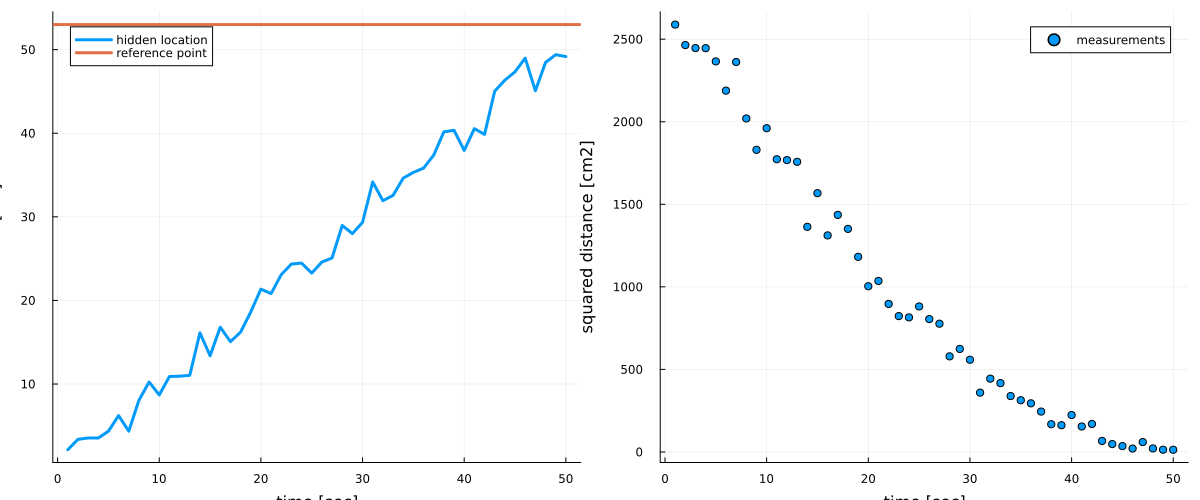

In [5]:
# plot hidden location and reference frame
p1 = plot(1:nr_observations, hidden_location, linewidth=3, legend=:topleft, label="hidden location")
hline!([reference_point], linewidth=3, label="reference point")
xlabel!("time [sec]"), ylabel!("location [cm]")

# plot measurements
p2 = scatter(1:nr_observations, measurements, linewidth=3, label="measurements")
xlabel!("time [sec]"), ylabel!("squared distance [cm2]")

plot(p1, p2, size=(1200, 500))

In [6]:
function compute_squared_distance(z)
    (z - reference_point)^2
end;

In [8]:
@model function measurement_model(nr_observations)

    # allocate random variables and observations
    z = randomvar(nr_observations)
    y = datavar(Float64, nr_observations)

    # set priors on precision parameters
    τ ~ Gamma(shape = 1.0, rate = 1.0e-12)
    γ ~ Gamma(shape = 1.0, rate = 1.0e-12)
    
    # specify estimate of initial location
    z[1] ~ Normal(mean = 0, precision = τ)
    y[1] ~ Normal(mean = compute_squared_distance(z[1]), precision = γ)

    # loop over observations
    for t in 2:nr_observations

        # specify state transition model
        z[t] ~ Normal(mean = z[t-1] + 1, precision = τ)

        # specify non-linear observation model
        y[t] ~ Normal(mean = compute_squared_distance(z[t]), precision = γ)
        
    end

end

In [9]:
@meta function measurement_meta(rng, nr_samples, nr_iterations, optimizer)
    compute_squared_distance() -> CVI(rng, nr_samples, nr_iterations, optimizer)
end;

In [10]:
@constraints function measurement_constraints()
    q(z, τ, γ) = q(z)q(τ)q(γ)
end;

In [16]:
results = inference(
    model = measurement_model(nr_observations),
    data = (y = measurements,),
    iterations = 5,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = measurement_constraints(),
    meta = measurement_meta(StableRNG(42), 100, 200, Descent(0.01)),
    initmessages = (z = NormalMeanVariance(0, 5),),
    initmarginals = (z = NormalMeanVariance(0, 5), τ = GammaShapeRate(1.0, 1.0e-12), γ = GammaShapeRate(1.0, 1.0e-12),),
)

MethodError: MethodError: no method matching getnode()
Closest candidates are:
  getnode(!Matched::ReactiveMP.EqualityChain, !Matched::Any) at ~/.julia/packages/ReactiveMP/BnYW1/src/nodes/equality.jl:82

In [24]:
using BenchmarkTools
@benchmark inference(
    model = measurement_model(nr_observations),
    data = (y = measurements,),
    iterations = 5,
    free_energy = true,
    returnvars = (z = KeepLast(),),
    constraints = measurement_constraints(),
    meta = measurement_meta(StableRNG(42), 100, 200, Descent(0.01)),
    initmessages = (z = NormalMeanVariance(0, 5),),
    initmarginals = (z = NormalMeanVariance(0, 5), τ = GammaShapeRate(1.0, 1.0e-12), γ = GammaShapeRate(1.0, 1.0e-12),),
)

BenchmarkTools.Trial: 41 samples with 1 evaluation.
 Range (min … max):  110.963 ms … 135.617 ms  ┊ GC (min … max): 0.00% … 12.29%
 Time  (median):     117.661 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   122.251 ms ±   8.474 ms  ┊ GC (mean ± σ):  5.01% ±  5.87%

                ▃█▃                                      ▁       
  ▇▇▄▁▁▄▁▁▁▁▁▄▁▇███▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▁▄▁▁▁▄▁▁▁▁▁▁▄▁▄▄█▇▁▄▄▇ ▁
  111 ms           Histogram: frequency by time          136 ms <

 Memory estimate: 66.10 MiB, allocs estimate: 2005806.

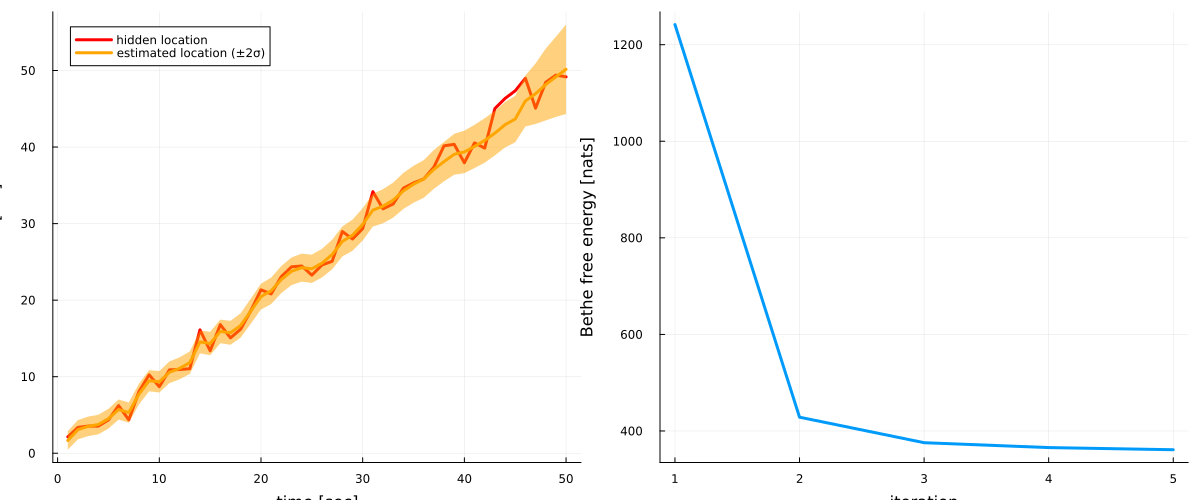

In [20]:
# plot estimates for location
p1 = plot(collect(1:nr_observations), hidden_location, label = "hidden location", legend=:topleft, linewidth=3, color = :red)
plot!(map(mean, results.posteriors[:z]), label = "estimated location (±2σ)", ribbon = map(x -> 2*std(x), results.posteriors[:z]), fillalpha=0.5, linewidth=3, color = :orange)
xlabel!("time [sec]"), ylabel!("location [cm]")

# plot Bethe free energy
p2 = plot(results.free_energy, linewidth=3, label = "")
xlabel!("iteration"), ylabel!("Bethe free energy [nats]")

plot(p1, p2, size = (1200, 500))